# NaiveBayesBaseline

### 230T2 - Megha Raveendran, Renee Reynolds, Derui Chen, Loïc Diridollou, Shiva Kandi

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# from google.colab import files, drive
import string
import datetime as dt

In [ ]:
import re
import nltk
import spacy
import string
from collections import Counter

from nltk.corpus import stopwords
nltk_stopwords = nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# read and process news data

In [ ]:
# drive.mount('/content/drive')
# path = "/content/drive/My Drive/data/"
path = "data\\"
new_df = pd.read_csv(path+"list_titles.csv")

Mounted at /content/drive


In [ ]:
new_df.drop('Unnamed: 0', axis = 1, inplace = True)
display(new_df.head())

,Date,Title,Return
0,2006-10-20,Exxon Mobil offers plan to end Alaska dispute,0.0012
1,2006-10-20,"Hey buddy, can you spare $600 for a Google sh...",0.0012
2,2006-10-21,AOL CEO says sales may shrink for two years -...,0.0000
3,2006-10-22,"Fed to keep hawkish tone, hold rates steady",0.0000
4,2006-10-22,Pluspetrol says losing $2.4 mln/day in Peru p...,0.0000


In [ ]:
# percentage of positive observations
Return = new_df.Return
return_pos = Return[Return>0]
1 - len(return_pos)/len(Return)

0.5220865438051037

In [ ]:
def preprocessing_text(df):
  df = df.copy()
  df.rename({"Title": "text"}, axis=1, inplace=True)

  # lower string
  df["text"] = df["text"].str.lower()

  # Removal of punctuation
  PUNCT_TO_REMOVE = string.punctuation
  def remove_punctuation(text):
      """custom function to remove the punctuation"""
      return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

  df["text"] = df["text"].apply(lambda text: remove_punctuation(text))

  # Removal of stopwords
  STOPWORDS = set(stopwords.words('english'))
  def remove_stopwords(text):
      """custom function to remove the stopwords"""
      return " ".join([word for word in str(text).split() if word not in STOPWORDS])
  df["text"] = df["text"].apply(lambda text: remove_stopwords(text))

  # Removal of infrequent words
  cnt = Counter()
  FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
  def remove_freqwords(text):
      """custom function to remove the frequent words"""
      return " ".join([word for word in str(text).split() if word not in FREQWORDS])

  df["text"] = df["text"].apply(lambda text: remove_freqwords(text))

  return df


df = preprocessing_text(new_df)
df.rename({"Return":"label"},axis=1,inplace=True)
df["label"] = np.sign(df["label"])
df["label"].replace(-1.0, 0.0, inplace=True)
display(df.head())

,Date,text,label
0,2006-10-20,exxon mobil offers plan end alaska dispute,1.0
1,2006-10-20,hey buddy spare 600 google share,1.0
2,2006-10-21,aol ceo says sales may shrink two years paper,0.0
3,2006-10-22,fed keep hawkish tone hold rates steady,0.0
4,2006-10-22,pluspetrol says losing 24 mlnday peru protest,0.0


In [ ]:
split_date = "2012-01-01"
train_df = df[df["Date"]<split_date]
test_df = df[df["Date"]>=split_date]
X_train = train_df["text"].values
y_train = train_df["label"].values
X_val = test_df["text"].values
y_val = test_df["label"].values

In [ ]:
print(train_df.shape)
print(test_df.shape)

(99955, 3)
(33203, 3)


# Train Naive Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])


# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
X_train_tfidf.data

array([0.27640659, 0.27640659, 0.27640659, ..., 0.22521057, 0.2050562 ,
       0.1923869 ])

In [ ]:
X_train_tfidf.data

array([0.27640659, 0.27640659, 0.27640659, ..., 0.22521057, 0.2050562 ,
       0.1923869 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


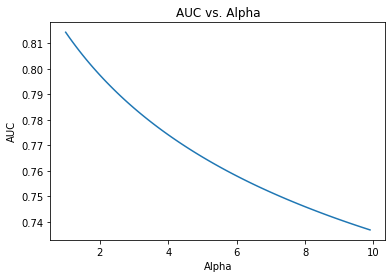

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1.0, 10, 0.1)],
                index=np.arange(1.0, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.5362
Accuracy: 52.86%


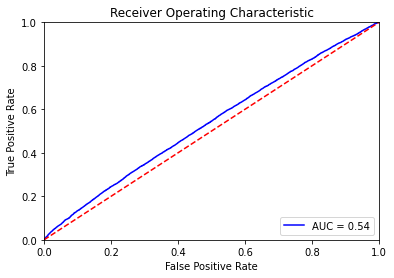

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)
ypred = nb_model.predict(X_val_tfidf)
# Evaluate the classifier
evaluate_roc(probs, y_val)

# Evaluate Correlation

In [ ]:
temperature_data = pd.read_csv(path+"temperature_random_data.csv") 
temperature_data = temperature_data[temperature_data["Date"]>=split_date]

In [ ]:
ret_data = pd.read_csv(path+"list_titles_new.csv")
ret_data = ret_data[ret_data["Date"]>=split_date]
ret_data = ret_data.groupby("Date")["Return"].first()

In [ ]:
probs_df = pd.DataFrame(probs[:,1], index=test_df["Date"])
probs_df["Date"] = probs_df.index
probs_df.index = range(len(probs_df))
probs_df = probs_df.groupby("Date").mean()
probs_df.columns = ["NaiveBayes"]
temperature_data.set_index('Date', inplace=True)

In [ ]:
temperature_data = pd.concat([temperature_data, probs_df, ret_data],axis=1)
temperature_data.rename({"temp_max":"temperature_max", "temp_min":"temperature_min","feels_like":"temperature_feels_like"},axis=1,inplace=True)

,correlation
temperature_max,0.165109
temperature_min,0.181668
temperature_feels_like,0.190742
uniform,-0.015761
normal,-0.055828
NaiveBayes,0.178732


Text(0.5, 1.0, 'correlation with S&P500 Close')

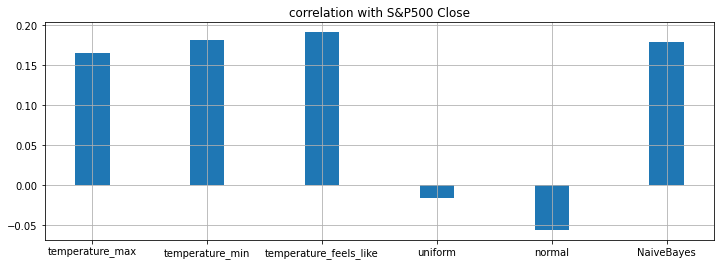

In [ ]:
corr_result = temperature_data.drop("Return",axis=1).corr()["Close"].to_frame().T[["temperature_max","temperature_min","temperature_feels_like","uniform","normal","NaiveBayes"]]
corr_result.index = ["correlation"]
plt.figure(figsize=(12,4))
plt.bar(["temperature_max","temperature_min","temperature_feels_like","uniform","normal","NaiveBayes"],corr_result.values.reshape((6)),width=0.3)
display(corr_result.T)
plt.grid()
plt.title("correlation with S&P500 Close")

In [ ]:
temperature_data

,temperature_max,temperature_min,temperature_feels_like,uniform,normal,Close,NaiveBayes,Return
Date,,,,,,,,
2012-01-01,8.879583,6.509167,3.863333,0.695013,-1.067619,NaN,0.374830,0.000000
2012-01-02,6.485000,5.414167,0.019167,0.843003,-0.272822,NaN,0.419543,0.000000
2012-01-03,-0.054583,-1.797500,-7.614167,0.068779,0.601926,1277.060059,0.498606,0.015474
2012-01-04,-5.902500,-7.775000,-13.589167,0.186527,0.236402,1277.300049,0.474116,0.000188
2012-01-05,0.455833,-0.739167,-5.794583,0.834327,0.050278,1281.060059,0.463175,0.002944
...,...,...,...,...,...,...,...,...
2013-11-16,11.864000,7.786400,6.899200,0.279084,-2.270418,NaN,0.406851,0.000000
2013-11-17,13.737692,10.497308,10.786538,0.650183,0.114760,NaN,0.420146,0.000000
2013-11-18,17.090741,14.509259,13.642222,0.583966,-1.390420,1791.530029,0.449262,-0.003698


,correlation
temperature_max,-0.024240
temperature_min,-0.022872
temperature_feels_like,-0.018739
uniform,0.010966
normal,0.006703
NaiveBayes,0.113718


Text(0.5, 1.0, 'correlation with S&P500 Return')

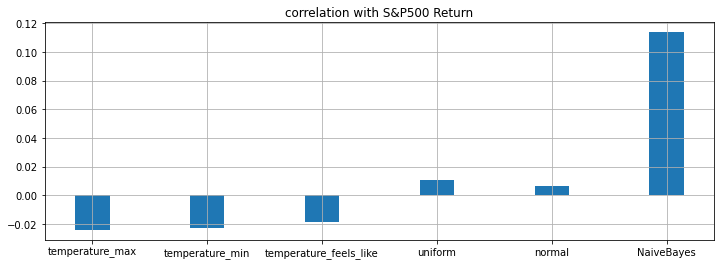

In [ ]:
corr_result = temperature_data.drop("Close",axis=1).corr()["Return"].to_frame().T[["temperature_max","temperature_min","temperature_feels_like","uniform","normal","NaiveBayes"]]
corr_result.index = ["correlation"]
plt.figure(figsize=(12,4))
plt.bar(["temperature_max","temperature_min","temperature_feels_like","uniform","normal","NaiveBayes"],corr_result.values.reshape((6)),width=0.3)
display(corr_result.T)
plt.grid()
plt.title("correlation with S&P500 Return")